# Literature Search

Here we will explore the prevalence of different measures of aperiodic activity in the literature.

To do so, we will use [LISC](https://github.com/lisc-tools/lisc), a Python module for collecting and analyzing scientific literature. More information on LISC can be found in the [documentation](https://lisc-tools.github.io/lisc/).

To explore the prevalence and use cases of aperiodic measures, we will collect information from the Pubmed database on the number of papers that include search terms mentioning aperiodic activity and measures, as well as the number of papers that mention these terms of interest in co-occurrence with specified association terms.

Note that collecting literature data in this way is likely an under-estimate of the use of these measures, as the approach employed here only searches for search terms occurring in abstracts.

In [1]:
import json

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Import LISC code
from lisc import Counts, Counts1D
from lisc.collect import collect_info, collect_counts, collect_across_time
from lisc.utils import save_object, load_object
from lisc.plts.counts import plot_matrix, plot_vector
from lisc.plts.time import plot_results_across_years

In [3]:
# Import custom code
import sys; from pathlib import Path
sys.path.append(str(Path('..').resolve()))
from apm.core.db import APMDB

In [4]:
import seaborn as sns
sns.set_context('talk')

## Settings

First, we will define some settings for the literature collection.

In [5]:
# Settings for literature collection
db = 'pubmed'
#db = 'pmc'

In [6]:
# Notebook settings
RUN_COLLECTION = True
SAVE_FIG = True
SAVE_DATA = True

In [7]:
# File path settings
APDB = APMDB()

In [8]:
# Settings for saving figures
SAVE_FIG = True
EXT = '.pdf'
FIGPATH = APDB.figs_path / '01_literature'

## Define Terms

Here we will define search terms to use to collect information on the literature of interest. 

### Search Terms

First, we will define the search terms that reflect our terms of interest.

Note that each set of terms within a list is a defined as a set of synonyms

In [9]:
# Set list of aperiodic terms & labels
concept_terms = [
    ['aperiodic', 'arrythmic'],
    ['1/f', '1/f-like'],
    ['fractal', 'scale free'],
    ['criticality'],
    ['complexity'],
]
concept_labels = ['aperiodic', '1/f', 'fractal', 'criticality', 'complexity']
assert len(concept_terms) == len(concept_labels)

In [10]:
# Set list of aperiodic method categories & labels
method_terms = [
    ['autocorrelation'],
    ['dfa', 'detrended fluctuation analysis', 'hurst exponent'],
    ['fractal exponent', 'higuchi', 'katz', 'petrosian'],
    ['entropy'],
    ['spectral parameterization', 'fooof', 'irasa', 'cgsa', 'aperiodic exponent', 'spectral slope'],
]
method_labels = ['autocorrelation', 'fluctuation', 'complexity', 'entropy', 'exponent']
assert len(method_terms) == len(method_labels)

In [11]:
# Set list of specific measures
measure_terms = [
    ['autocorrelation'],
    ['autocorrelation decay'],
    ['hurst exponent'],
    ['detrended fluctuation analysis', 'dfa'],
    ['hjorth'],
    ['katz fractal dimension'],
    ['lempel-ziv complexity'],
    ['approximate entropy'],
    ['sample entropy'],
    ['permutation entropy'],
    ['spectral entropy'],
    ['multiscale entropy'],
    ['irasa', 'irregular resampling auto-spectral analysis'],
    ['specparam', 'spectral parameterization', 'fooof', 'fitting oscillations and one-over f'],
]

### Inclusion / Exclusion Terms

In some cases, we might want to use additional search terms to explicit include or exclude results that contain particular terms. 

These terms can be used to restrict searches to literature of interest, excluding irrelevant literature. 

In [12]:
# Set inclusion / exclusion terms
inclusions = [
    'EEG', 'electroencephalography',
    'MEG', 'magnetoencephalography', 
    'ECoG', 'electrocorticography',
    'iEEG', 'intracranial EEG',
    'LFP', 'local field potential',
]

exclusions = ['lithium']

In [13]:
# Define a list of association terms
assoc_terms = [
    ['aging', 'development'],
    ['cognitive', 'cognition', 'task', 'behavior'],
    ['sleep', 'anesthesia', 'consciousness'],
    ['clinical', 'disease', 'disorder', 'psychopathology'],
    ['epilepsy', 'seizure'],
]

### Collect terms

In [14]:
# Collect all terms together
concept_terms_dict = {
    'terms' : concept_terms,
    'labels' : concept_labels,
    'inclusions' : [inclusions] * len(concept_terms),
    'exclusions' : [exclusions] * len(concept_terms),
}

method_terms_dict = {
    'terms' : method_terms,
    'labels' : method_labels,
    'inclusions' : [inclusions] * len(method_terms),
    'exclusions' : [exclusions] * len(method_terms),
}

measure_terms_dict = {
    'terms' : measure_terms,
    'inclusions' : [inclusions] * len(measure_terms),
    'exclusions' : [exclusions] * len(measure_terms),
}

## Run a Metadata Check

In [47]:
# if RUN_COLLECTION:
#     meta_data = collect_info()
    
#     # Save out meta data information
#     if SAVE_DATA:
#         with open(APDB.literature_path / 'meta_data.json', 'w') as save_file:
#             json.dump(meta_data.as_dict(), save_file)

# else:
#     with open(APDB.literature_path / 'meta_data.json', 'r') as f_obj:
#         meta_data = json.load(f_obj)

In [46]:
# # Check the meta data for the collection
# meta_data

## Add & Check Terms

Now we can add these terms to LISC objects, ready for data collection. 

In [17]:
# Initialize & add terms to the LISC object - concepts
counts_concepts = Counts()
counts_concepts.add_terms(concept_terms_dict, dim='A')
counts_concepts.add_terms(assoc_terms, dim='B')

In [18]:
# Initialize & add terms to the LISC object - methods
counts_methods = Counts()
counts_methods.add_terms(method_terms_dict, dim='A')
counts_methods.add_terms(assoc_terms, dim='B')

In [19]:
# Initialize & add terms to the LISC object - measures (no associations)
counts_measures = Counts1D()
counts_measures.add_terms(measure_terms_dict)

In [20]:
# Check terms - concepts
counts_concepts.terms['A'].check_terms()

List of terms used: 

aperiodic    : aperiodic, arrythmic
1/f          : 1/f, 1/f-like
fractal      : fractal, scale free
criticality  : criticality
complexity   : complexity


In [21]:
# Check terms - methods
counts_methods.terms['A'].check_terms()

List of terms used: 

autocorrelation  : autocorrelation
fluctuation      : dfa, detrended fluctuation analysis, hurst exponent
complexity       : fractal exponent, higuchi, katz, petrosian
entropy          : entropy
exponent         : spectral parameterization, fooof, irasa, cgsa, aperiodic exponent, spectral slope


In [22]:
# Check terms - measures
counts_measures.check_terms()

List of terms used: 

autocorrelation                 : autocorrelation
autocorrelation decay           : autocorrelation decay
hurst exponent                  : hurst exponent
detrended fluctuation analysis  : detrended fluctuation analysis, dfa
hjorth                          : hjorth
katz fractal dimension          : katz fractal dimension
lempel-ziv complexity           : lempel-ziv complexity
approximate entropy             : approximate entropy
sample entropy                  : sample entropy
permutation entropy             : permutation entropy
spectral entropy                : spectral entropy
multiscale entropy              : multiscale entropy
irasa                           : irasa, irregular resampling auto-spectral analysis
specparam                       : specparam, spectral parameterization, fooof, fitting oscillations and one-over f


In [23]:
# Check terms - associations
counts_concepts.terms['B'].check_terms()

List of terms used: 

aging      : aging, development
cognitive  : cognitive, cognition, task, behavior
sleep      : sleep, anesthesia, consciousness
clinical   : clinical, disease, disorder, psychopathology
epilepsy   : epilepsy, seizure


## Collect Literature Data

Run literature collection. 

In [24]:
# Run the data collection
if RUN_COLLECTION:
    counts_concepts.run_collection(db=db)
    counts_methods.run_collection(db=db)
    counts_measures.run_collection(db=db)
else:
    counts_concepts = load_object('counts_concepts.p', directory=APDB.literature_path)
    counts_methods = load_object('counts_methods.p', directory=APDB.literature_path)

## Check and Process Collected Data

Now we can examine the collected literature data.

In [25]:
# Check how many papers were found for each term (concepts)
counts_concepts.check_counts()

The number of documents found for each search term is:
  'aperiodic'     -    196
  '1/f'           -    186
  'fractal'       -    502
  'criticality'   -    106
  'complexity'    -   2462


In [26]:
# Check how many papers were found for each term (methods)
counts_methods.check_counts()

The number of documents found for each search term is:
  'autocorrelation'   -    162
  'fluctuation'       -    224
  'complexity'        -    125
  'entropy'           -   1969
  'exponent'          -     63


In [27]:
# Check how many papers were found for each term (measures)
counts_measures.check_counts()

The number of documents found for each search term is:
  'autocorrelation'                  -   162
  'autocorrelation decay'            -     3
  'hurst exponent'                   -    64
  'detrended fluctuation analysis'   -   171
  'hjorth'                           -   109
  'katz fractal dimension'           -     8
  'lempel-ziv complexity'            -   148
  'approximate entropy'              -   253
  'sample entropy'                   -   292
  'permutation entropy'              -   152
  'spectral entropy'                 -   207
  'multiscale entropy'               -   158
  'irasa'                            -     9
  'specparam'                        -    21


In [28]:
# Check the total number of papers across all terms
print('Total number of aperiodic papers (concepts): \t',
      sum(counts_concepts.terms['A'].counts))
print('Total number of aperiodic papers (methods): \t',
      sum(counts_methods.terms['A'].counts))
print('Total number of aperiodic papers (measures): \t',
      sum(counts_measures.counts))

Total number of aperiodic papers (concepts): 	 3452
Total number of aperiodic papers (methods): 	 2543
Total number of aperiodic papers (measures): 	 1757


In [29]:
# Normalize the association results
counts_concepts.compute_score('normalize', dim='A')
counts_methods.compute_score('normalize', dim='A')

## Create Visualizations of Collected Data

### Concepts

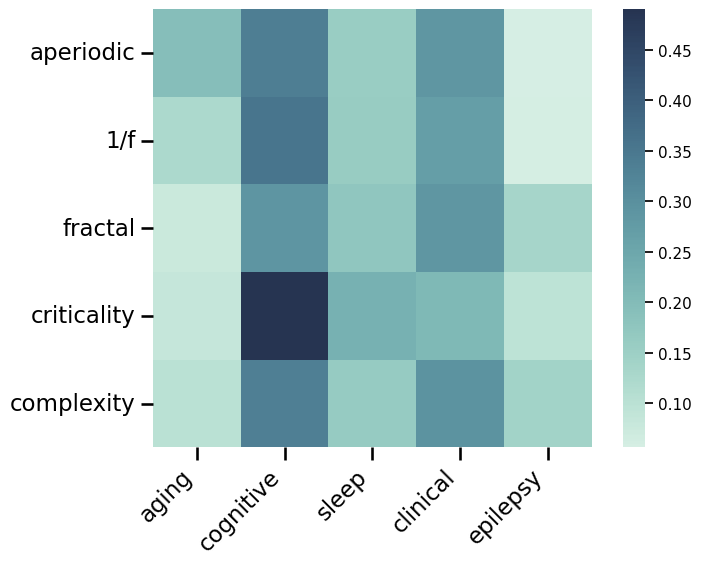

In [30]:
# Plot the associations of aperiodic measures in the literature
fig, ax = plt.subplots(figsize=(8, 6))
plt.xticks(rotation=45, horizontalalignment='right');
plot_matrix(counts_concepts.score, counts_concepts.terms['B'].labels,
            counts_concepts.terms['A'].labels, cmap='blue', square=True, ax=ax,
            save_fig=SAVE_FIG, file_name='lit_counts_concepts' + EXT, directory=FIGPATH)

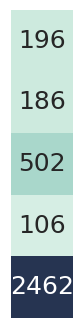

In [31]:
# Plot the number of papers found per ratio measure
plot_vector(counts_concepts, cmap='blue', figsize=(1.5, 4),
            save_fig=SAVE_FIG, file_name='total_counts_concepts' + EXT, directory=FIGPATH)

### Methods

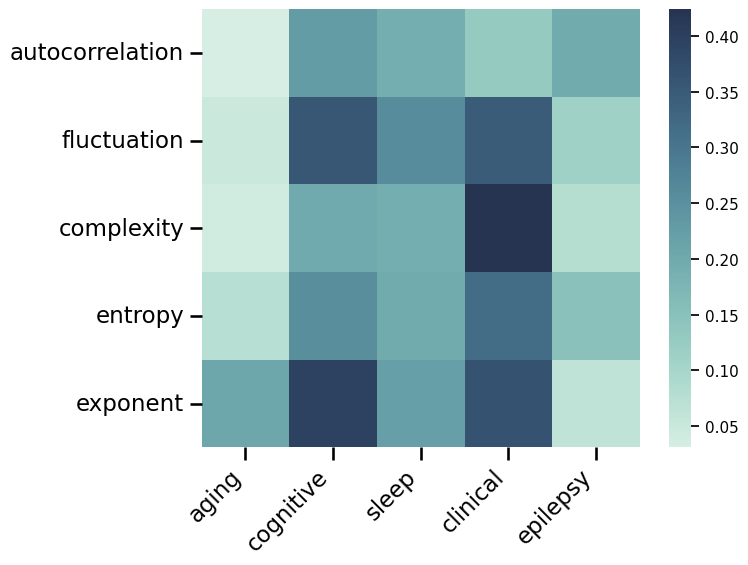

In [32]:
# Plot the associations of aperiodic measures in the literature
fig, ax = plt.subplots(figsize=(8, 6))
plt.xticks(rotation=45, horizontalalignment='right');
plot_matrix(counts_methods.score, counts_methods.terms['B'].labels,
            counts_methods.terms['A'].labels, cmap='blue', square=True, ax=ax,
            save_fig=SAVE_FIG, file_name='lit_counts_methods' + EXT, directory=FIGPATH)


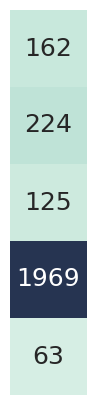

In [33]:
# Plot the number of papers found per ratio measure
plot_vector(counts_methods, cmap='blue', figsize=(2, 5),
            save_fig=SAVE_FIG, file_name='total_counts_methods' + EXT, directory=FIGPATH)

### Measures

In [34]:
## ToDo: To FIX
# # Plot the number of papers found per ratio measure
# plot_vector(counts_measures, cmap='blue', transpose=True, figsize=(15, 1.5),
#             save_fig=SAVE_FIG, file_name='total_counts_measures' + EXT, directory=FIGPATH)

In [35]:
# Save out the collected data
if SAVE_DATA:
    save_object(counts_concepts, 'counts_concepts', directory=APDB.literature_path)
    save_object(counts_methods, 'counts_methods', directory=APDB.literature_path)
    save_object(counts_methods, 'counts_measures', directory=APDB.literature_path)

## Examine Literature Terms over Time

Note: potential ToDo - turn `collect_over_time` into a function to add to LISC.

In [36]:
# Define range of years to collect data for
start_year, end_year = 1960, 2023
years = list(range(start_year, end_year + 1))

In [37]:
# Collect count of the number of aperiodic related papers per year
if RUN_COLLECTION:
    
    # Setup object and run time collecting - concepts
    years_concepts = Counts1D()
    years_concepts.add_terms(concept_terms_dict)
    years_concept_results = collect_across_time(years_concepts, years)
    
    # Setup object and run time collecting - methods
    years_methods = Counts1D()
    years_methods.add_terms(method_terms_dict)
    years_method_results = collect_across_time(years_methods, years) 

/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/bs4/builder/__init__.py:545: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  warnings.warn(


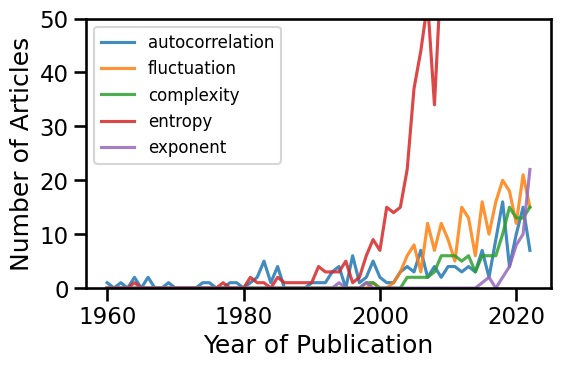

In [43]:
plot_results_across_years(years_method_results, ylim=[0, 50])

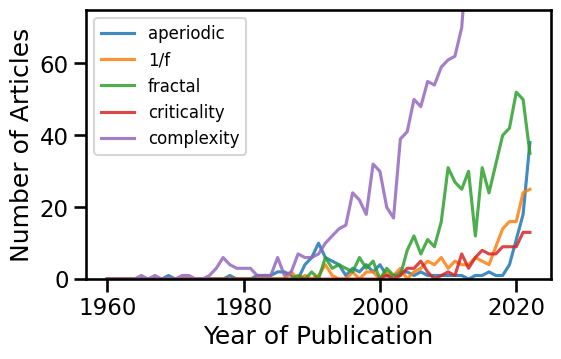

In [45]:
plot_results_across_years(years_concept_results, ylim=[0, 75])